8-bands H_0 Hamiltonian from Kane interaction matrix:

Brillouin Zone points cheatsheet:

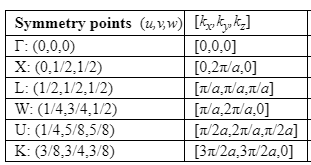

In [1]:
import numpy as np
import matplotlib.pyplot as plt

GaAs calculations:

### Parameters:

In [8]:
# ---- constants ----
# all in electronovolts
h = 4.135667696e-15
h_bar = 6.582119569e-16
m_0 = 5.686e-12 #eV*s/A^2
J_to_eV = 1

# # all in Si
# h = 6.626e-34
# h_bar = 1.054571e-34
# m_0 = 9.109383e-31

eV_to_J = 1.602176e-19
J_to_eV = 1/eV_to_J
h_bar2_2m = 3.81e-20 #ev*Angstr.^2

# ---- material parameters ----
# GaAs
# Define the material parameters
a_lc = 5.65325e-10
E_g = 1.519 # Bandgap energy
E_p = 25.6#*eV_to_J
#P_cv = h_bar*np.sqrt(E_p/(2*m_0)) # zmienić na formułę z h_bar2_2m
P_cv = np.sqrt(E_p*h_bar2_2m)

F = -1.94
delta_so = 0.341

# Define the spin-orbit coupling constants
gamma_1 = 6.98
gamma_2 = 2.06
gamma_3 = 2.93

# ---- tensions paramters ----
c_11 = 1221e9
c_12 = 566e9

epsilon_xx = -0.02
epsilon_yy = epsilon_xx
epsilon_zz = -(c_11+c_12)*epsilon_xx/c_11
a_c = -7.17
a_v = -1.16
b = -2.0
d = -4.8

# ---- calculation parameters ----
points = 100
k_top = 0.5

### Hamiltonian:

#### Full:

In [3]:
def four_band_interaction_full_for_III_V_semicond_Hamiltonian(k):
    """k needs to be in angstrems

    Args:
        k (_type_): _description_

    Returns:
        _type_: _description_
    """
    # Define the 8x8 Hamiltonian matrix
    H = np.zeros((4,4), dtype=np.complex128)
    
    # with conversion of values from p. 189 
    # file:///D:/Nauka/in%C5%BCynierka/bands-and-photons-in-iii-
    # v-semiconductor-quantum-structures-0198767277-9780198767275_compress.pdf
    
    L = h_bar2_2m*(gamma_1+4*gamma_2-E_p/E_g)*0.28106069
    M = h_bar2_2m*(gamma_1-2*gamma_2)*0.26315789
    N = h_bar2_2m*(6*gamma_3-E_p/E_g)*0.22292891
        
    # Fill in the diagonal elements of the Hamiltonian
    H[0,0] = E_g + h_bar2_2m*np.dot(k,k)*(1+2*F)
    H[1,1] = -L*k[0]**2-M*(k[1]**2+k[2]**2)
    H[2,2] = -L*k[1]**2-M*(k[0]**2+k[2]**2)
    H[3,3] = -L*k[2]**2-M*(k[0]**2+k[1]**2)
    
    # Fill in the off-diagonal elements of the Hamiltonian
    H[0,1] = 1j*h_bar/m_0*k[0]*P_cv
    H[0,2] = 1j*h_bar/m_0*k[1]*P_cv
    H[0,3] = 1j*h_bar/m_0*k[2]*P_cv
    H[1,0] = -H[0,1]
    H[2,0] = -H[0,2]
    H[3,0] = -H[0,3]
    
    H[1,2] = -N*k[0]*k[1]#*1e10
    H[2,1] = H[1,2]
    H[1,3] = -N*k[0]*k[2]#*1e10
    H[3,1] = H[1,3]
    H[2,3] = -N*k[1]*k[2]#*1e10
    H[3,2] = H[2,3]
    
    # The Hamiltonian matrix is now fully defined and can be used for further calculations
    return H

def eight_band_full_for_III_V_semicond_Hamiltonian(k):
    H_full = np.zeros((8,8), dtype=np.complex128)

    H_full[1,7] = H_full[7,1] = delta_so/3
    H_full[3,5] = H_full[5,3] = -H_full[1,7]
    H_full[2,1] = H_full[3,6] = H_full[5,6] = H_full[7,2] = 1j*delta_so/3
    H_full[1,2] = H_full[2,7] = H_full[6,3] = H_full[6,5] = -H_full[2,1]
    
    H_4x4 = four_band_interaction_full_for_III_V_semicond_Hamiltonian(k)    
    
    H_full[:4,:4] += H_4x4
    H_full[4:,4:] += H_4x4
    
    return H_full

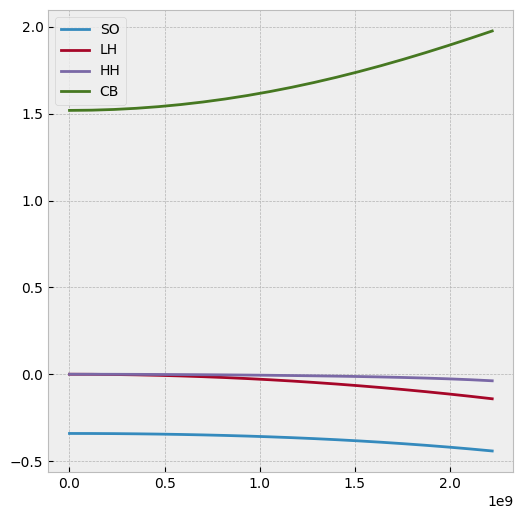

In [26]:
def calc_band_diagram(points=20):
    band_diagram = np.zeros((8,points), dtype=np.float64)
  
    k_i = np.linspace(0,
                    0.2*2*np.pi/a_lc,
                    points)
    for i, k_z in enumerate(k_i):      
        H = eight_band_full_for_III_V_semicond_Hamiltonian([0,0,k_z/1e10])
        evals, evects = np.linalg.eigh(H)
        band_diagram[:,i] = evals.astype(np.float64)


    return band_diagram, k_i

raw_bd, k_x = calc_band_diagram(20)

bd = raw_bd[::2,:]

bd[0,:] = bd[0,:]-bd[1,0]
bd[1,:] = bd[1,:]-bd[1,0]
bd[2,:] = bd[2,:]-bd[2,0]
# bd[2,:] = -bd[2,:]
bd[3,:] = 2*E_g-bd[3,:]

with plt.style.context('bmh'):
    plt.figure(figsize=(6,6))
    bands_names = ['SO','LH','HH','CB']

    for band in range(4):
        plt.plot(k_x, bd[band], '-', label=f'{bands_names[band]}')
    plt.legend()
    plt.show()

#### Approximated:

In [59]:
def four_band_interaction_appr_for_III_V_semicond_Hamiltonian(k):
    """k needs to be in angstrems

    Args:
        k (_type_): _description_

    Returns:
        _type_: _description_
    """
    # Define the 8x8 Hamiltonian matrix
    H = np.zeros((4,4), dtype=np.complex128)
    
    L = h_bar2_2m*(gamma_1+4*gamma_2-E_p/E_g)
    M = h_bar2_2m*(gamma_1-2*gamma_2)
    N = h_bar2_2m*(6*gamma_3-E_p/E_g)
    
    A = L+h_bar2_2m*E_p/E_g
    A_prim = L+h_bar2_2m*E_p*(1/(E_g+delta_so) - 1/E_g)
    A = A_prim # UNCOMMENT IF SO INCORPORATED
    B = M
    C = N+h_bar2_2m*E_p/E_g
    D = h_bar2_2m*(1+2*F+E_p/E_g)

    # Fill in the diagonal elements of the Hamiltonian
    H[0,0] = E_g + D*np.dot(k,k)
    H[1,1] = -A*k[0]**2-B*(k[1]**2+k[2]**2)
    H[2,2] = -A*k[1]**2-B*(k[0]**2+k[2]**2)
    H[3,3] = -A*k[2]**2-B*(k[0]**2+k[1]**2)
    
    # Fill in the off-diagonal elements of the Hamiltonian
    H[1,2] = -C*k[0]*k[1]
    H[2,1] = H[1,2]
    H[1,3] = -C*k[0]*k[2]
    H[3,1] = H[1,3]
    H[2,3] = -C*k[1]*k[2]
    H[3,2] = H[2,3]
    
    # The Hamiltonian matrix is now fully defined and can be used for further calculations
    return H

def eight_band_appr_for_III_V_semicond_Hamiltonian(k):
    H = np.zeros((8,8), dtype=np.complex128)

    H[1,7] = H[7,1] = delta_so/3
    H[3,5] = H[5,3] = -H[1,7]
    H[2,1] = H[3,6] = H[5,6] = H[7,2] = 1j*delta_so/3
    H[1,2] = H[2,7] = H[6,3] = H[6,5] = -H[2,1]
    
    H_4x4 = four_band_interaction_appr_for_III_V_semicond_Hamiltonian(k)
    
    H[:4,:4] += H_4x4
    H[4:,4:] += H_4x4
    
    return H

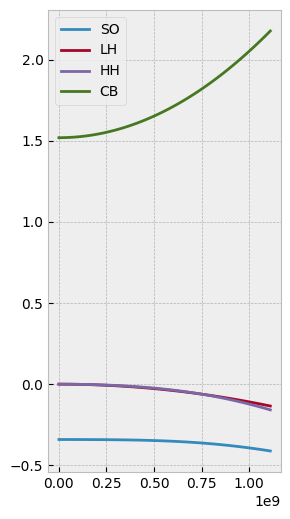

In [60]:
def calc_band_diagram(points=20):
    band_diagram = np.zeros((8,points), dtype=np.float64)
  
    k_i = np.linspace(0,
                    0.1*2*np.pi/a_lc,
                    points)
    for i, k_z in enumerate(k_i):      
        H = eight_band_appr_for_III_V_semicond_Hamiltonian([0,0,k_z])
        evals, evects = np.linalg.eigh(H)
        band_diagram[:,i] = evals.astype(np.float64)
        # if i==0:
        #     print(np.round(H, 2))

    return band_diagram, k_i

raw_bd, k_x = calc_band_diagram(100)

bd = raw_bd[::2,:]

bd[0,:] = bd[0,:]-bd[1,0]
bd[1,:] = bd[1,:]-bd[1,0]
bd[2,:] = bd[2,:]-bd[2,0]
bd[2,:] = -bd[2,:]

with plt.style.context('bmh'):
    plt.figure(figsize=(3,6))
    bands_names = ['SO','LH','HH','CB']

    for band in range(4):
        plt.plot(k_x, bd[band], '-', label=f'{bands_names[band]}')
    plt.legend()
    plt.show()

### With strains:

In [9]:
def four_band_strains_full_for_III_V_semicond_Hamiltonian(k):
    """k needs to be in angstrems

    Args:
        k (_type_): _description_

    Returns:
        _type_: _description_
    """
    # Define the 8x8 Hamiltonian matrix
    H = np.zeros((4,4), dtype=np.complex128)
    
    # with conversion of values from p. 189 
    # file:///D:/Nauka/in%C5%BCynierka/bands-and-photons-in-iii-
    # v-semiconductor-quantum-structures-0198767277-9780198767275_compress.pdf
    
    l_epsilon = 2*b+a_v#*0.28106069
    m_epsilon = a_v-b#*0.26315789
    n_epsilon = np.sqrt(3)*d#*0.22292891
        
    # Fill in the diagonal elements of the Hamiltonian
    H[0,0] = a_c*(epsilon_xx+epsilon_yy+epsilon_zz)
    H[1,1] = l_epsilon*epsilon_xx+m_epsilon*(epsilon_yy+epsilon_zz)
    H[2,2] = l_epsilon*epsilon_yy+m_epsilon*(epsilon_xx+epsilon_zz)
    H[3,3] = l_epsilon*epsilon_zz+m_epsilon*(epsilon_xx+epsilon_yy)

    # The Hamiltonian matrix is now fully defined and can be used for further calculations
    return H

def eight_band_strain_full_for_III_V_semicond_Hamiltonian(k):
    H_full = np.zeros((8,8), dtype=np.complex128)

    H_full[1,7] = H_full[7,1] = delta_so/3
    H_full[3,5] = H_full[5,3] = -H_full[1,7]
    H_full[2,1] = H_full[3,6] = H_full[5,6] = H_full[7,2] = 1j*delta_so/3
    H_full[1,2] = H_full[2,7] = H_full[6,3] = H_full[6,5] = -H_full[2,1]
    
    H_4x4_strains = four_band_strains_full_for_III_V_semicond_Hamiltonian(k)
    H_4x4_int = four_band_interaction_full_for_III_V_semicond_Hamiltonian(k)
    
    H_full[:4,:4] += H_4x4_int+H_4x4_strains
    H_full[4:,4:] += H_4x4_int+H_4x4_strains
    
    return H_full

In [17]:
def calc_band_diagram(k_top=1, points=20):
    band_diagram = np.zeros((8,points,points,points), dtype=np.float64)
    strained_band_diagram = np.zeros((8,points,points,points), dtype=np.float64)
  
    k_range = np.linspace(0,
                    k_top*2*np.pi/a_lc,
                    points)
    for i_x, k_x in enumerate(k_range):
        print(f'[{i_x+1}/{points}]', end='\r')
        for i_y, k_y in enumerate(k_range):
            for i_z, k_z in enumerate(k_range):
                H = eight_band_full_for_III_V_semicond_Hamiltonian([k_x,k_y,k_z])
                evals, evects = np.linalg.eigh(H)
                band_diagram[:,i_x,i_y,i_z] = evals.astype(np.float64)
                
                H = eight_band_strain_full_for_III_V_semicond_Hamiltonian([k_x,k_y,k_z])
                evals, evects = np.linalg.eigh(H)
                strained_band_diagram[:,i_x,i_y,i_z] = evals.astype(np.float64)


    return band_diagram, strained_band_diagram, k_range

raw_bd, raw_str_bd, k_i = calc_band_diagram(k_top, points)

In [18]:
# we need any of the spins from all possible states
bd = raw_bd[::2]
str_bd = raw_str_bd[::2]

str_bd[0,:] = str_bd[0,:]-bd[1,0,0,0]
str_bd[1,:] = str_bd[1,:]-bd[1,0,0,0]
str_bd[2,:] = str_bd[2,:]-bd[2,0,0,0]
# str_bd[2,:] = -str_bd[2,:]
str_bd[3,:] = 2*str_bd[3,0,0,0]-str_bd[3,:]

bd[0,:] = bd[0,:]-bd[1,0,0,0]
bd[1,:] = bd[1,:]-bd[1,0,0,0]
bd[2,:] = bd[2,:]-bd[2,0,0,0]
# bd[2,:] = -bd[2,:]
bd[3,:] = 2*bd[3,0,0,0]-bd[3,:]

np.save(f'./results/GaAs_300k_8kp_no-strain_{points}points_top{k_top}.npy', bd)
np.save(f'./results/GaAs_300k_8kp_strain{epsilon_xx}_{points}points_top{k_top}.npy', str_bd)

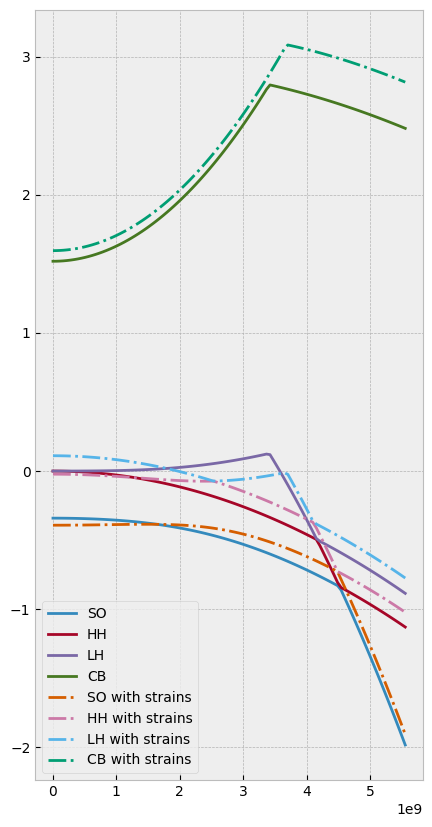

In [19]:
# only k_y direction
bd = bd[:,0,0,:]
str_bd = str_bd[:,0,0,:]

with plt.style.context('bmh'):
    bands_names = ['SO','HH','LH','CB']
    
    plt.figure(figsize=(5,10))
    for band in range(4):
        plt.plot(k_i, bd[band], '-', label=f'{bands_names[band]}')
    
    for band in range(4):
        plt.plot(k_i, str_bd[band], '-.', label=f'{bands_names[band]} with strains')
    plt.legend()
    plt.show()